<center>

**Harry Podolsky**

**Roux Institute, Northeastern University**

**ALY 6140**

**Professor Patrick McQuillan**


**Final Project: Solar Farm Data Analysis**

</center>




















**Introduction**

This project will examine trends and dynamics at play for a photovoltaic (PV) generation plant over a 34 day period. The project is located in India. I will examine patterns and project performance over time. After parsing the data, standardizing data types, and creating additional variables of interest, I will build out functions to streamline visualization of the data using Plotly. Then I will look at correlations between all of the variables and attempt to model them. I will focus on PV panel efficiency as the dependent variable, with the project level and weather data as explanatory variables. I will divide the data into training and testing sets and then overlay the modelled results for the testing period over the actual results from that period. I will build models to describe and predict efficiency of the PV panels based on the explanatory variables.

This project data comes from two separate files. One contains 15-minute observations of a solar generation plants in India over a 34 day period. Each individual inverter on the project has an observation on each interval, so there are 22 observations per unique timestamp for the generation file. The raw data reads in from two .csv files as character, float, and int data. Data type conversion will be necessary. Generation data variables include date-time, plant ID, a unique source key which maps to an individual inverter's output, DC power in kW (direct current generation from the panel into the inverter), AC Power in kW (AC power output from the inverter), plus daily and total yield sums. The other file contains 15-minute observations for weather at each plant, containing date-time, plant ID, a unique source key that maps to the collection device, ambient temperature at the farm in Celsius, module temperature at panel level in Celsius (note only one panel on each plant is being measured for this variable), and irradiation, measured in kWh per m^2. Most of the variables are numeric, with IDs and dates as the only raw categorical variables. I also add a categorical variable based on energy demand trends on the grid - assigning each timestamp to on-peak, off-peak, and night.


**Data Extraction, Cleaning, and Transformation**

In the following code chunks I focus on reading in, aggregating, and visualizing the weather and generation paired datasets for the solar project called Plant 1. Date-time formating in the raw datasets differs slightly between generation and weather sets, which led to some extensive troubleshooting in order to have Pandas read them correctly. 
    

In [19]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import string
from tabulate import tabulate
from datetime import datetime
from IPython.display import display

Below are samples of the raw .csv files for generation and weather data. Note the differences in how the date-time variables are formated. Also note that the Plant_ID is the same for both files - the data pertains to the same PV asset.

In [24]:
#Reading in the data
generation1 = pd.read_csv("Plant_1_Generation_Data.csv",header=0)
weather1 = pd.read_csv("Plant_1_Weather_Sensor_Data.csv",header=0)
raw_gen_samp=pd.DataFrame(generation1.head())
raw_weather_samp = pd.DataFrame(weather1.head())

print(f"Generation Data Sample:")
display(raw_gen_samp)

print(f"Weather Data Sample:")
display(raw_weather_samp)


Generation Data Sample:


,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


Weather Data Sample:


,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,5/15/20 0:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,5/15/20 0:15,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2,5/15/20 0:30,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
3,5/15/20 0:45,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
4,5/15/20 1:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0


In [4]:
"""Storing unique inverter keys as a list, before creating a dictionary mapping alphabetical letters to unique
inverter keys.I use a list comprehension to loop through the alphabet and assign lower case letters alphabetically
up to the lengthof the list of unique keys (22 letters). I did this because I find the convoluted inverter keys
irritating to work with, so I renamed them."""

unique = generation1['SOURCE_KEY'].unique().tolist()
alphabet = [letter for letter in string.ascii_lowercase][:len(unique)]
code_mapping = zip(unique, alphabet)
code_mapping = dict(code_mapping)

In [25]:
#replacing convoluted source keys with simple alphabetical keys using lambda function within .apply()
generation1['SOURCE_KEY'] = generation1['SOURCE_KEY'].apply(lambda x: code_mapping.get(x))
display(generation1.head())

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,a,0.0,0.0,0.0,6259559.0
1,15-05-2020 00:00,4135001,b,0.0,0.0,0.0,6183645.0
2,15-05-2020 00:00,4135001,c,0.0,0.0,0.0,6987759.0
3,15-05-2020 00:00,4135001,d,0.0,0.0,0.0,7602960.0
4,15-05-2020 00:00,4135001,e,0.0,0.0,0.0,7158964.0


In [6]:
"""The two datasets cover the exact same date-times, but the date-time variables are formated differently in each. 
pd.to_datetime() reads one correctly, but completely misinterprets the other. I got around this (after some difficulty)
by again using a lambda function to apply the datetime.strptime() method to the raw date variable in both 
datasets, using the proper datetime format for each dataset."""

generation1['DATE_TIME'] = generation1['DATE_TIME'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y %H:%M'))
weather1['DATE_TIME'] = weather1['DATE_TIME'].apply(lambda x: datetime.strptime(x, '%m/%d/%y %H:%M'))

After this initial cleaning, I now have two pandas dataframes covering identical time spans. In the following code chunks I join the two datasets, then aggregate up from 15-minute intervals to one hour in order to have a more manageable single dataframe. Joining weather and generation data together is complicated by the fact that the generation dataset has 22 inverter observations for each timestamp, compared to the weather data with only one observation per. My approach is to left join weather to generation as a starting point. This creates duplicates in the weather data for the new set (violating normal form), but sets me up to aggregate on DATE_TIME, creating a dataframe with the sum and mean inverter-level AC and DC output for each interval, total project generation for each interval, and weather information from that point in time. 

Below I join the two datasets, I completed data transformations to add two additional inverter-level datapoints. Inverter efficiency is AC output per unit of DC input to each inverter (stored as a ratio):

***Inverter Efficiency = AC Output / DC Input***

My hypothesis is that inverter efficiency does not vary widely, but I want to look for a pattern if there is variance in the inverter efficiency variable. Solar systems are generally set up with one or more individual photovoltaic (PV) panels feeding to a single inverter. I want to see how each inverter's set of panels compare, and also examine project-level efficiency at different times of day. DC production efficiency is one measure of the photovoltaic (PV) generation efficiency from the string of panels connected to each inverter.  This is the classic formula for PV efficiency:


<b><i>Efficiency = DC Output / (Irradiation * Panel Area)</i></b>

Unfortunately, surface area information for each string of panels is not available for this solar project. I had to find a different method for calculating efficiency, and instead used a formula that estimates efficiency by relating actual output to maximum panel output under standard test conditions (STC). To do so I store an assumed value for STC output based on the National Renewable Energy Laboratory (NREL) statement that average STC power ratings for a crystalline silicon PV module range from about 250 to 360 Watts. I went with 300W. This allows me to apply the following formula to find panel efficiency (as a ratio of theoretical maximum production):

<b><i>Efficiency = (DC Output / (STC Power * Irradiance))/100</i></b>

This sets me up to examine generation efficiency as a function of weather factors and other variables, which could begin with simply correlation analysis. NOTE: I did elect to use an assumption here around power ratings for the panels. I acknowledge that the efficiency values I generate are estimates as a result. The assumption is based on NREL data, and I will build a model to describe variation in this efficiency value.

In [7]:
# function that takes a df as input and returns the column names along with a boolean 
# indicating the presence or absence of NaN values, and a count of any NA values.    

def na_check(df_name):
    na_present = np.where(df_name.isna().any(), 'yes', 'no')
    na_count = df_name.isna().sum().values
    df_result = pd.DataFrame({
        'column_name': df_name.columns,
        'is.na': na_present,
        'count': na_count
    })
    return df_result


In [27]:
# storing raw joined data as a separate df
plant1_raw = pd.merge(generation1, weather1,on='DATE_TIME',how='left')
# copying raw data to add additional variables
plant1_df = plant1_raw
"""creating new variables, 
 This needs to be implemented in plant1_raw so I can compare individual inverter performances.
 Due to zero irradiation at night, I apply a minimum threshold to avoid NaN from dividing by zero."""
 
plant1_df['inverter_efficiency'] = ((plant1_df['AC_POWER'] / plant1_df['DC_POWER']).apply(lambda x: x if x > .0001 else 0))

stc_power = 300 #rating in Watts, assumed value.
#when irradiation is 0, automatically insert an efficiency of 0 rather than Nan. PV efficiency is always 0 when there is no sun!
plant1_df['PV_efficiency'] = np.where(plant1_df['IRRADIATION'] == 0, 0, (plant1_df['DC_POWER'] / (stc_power * plant1_df['IRRADIATION'])) / 100)

plant1_df_samp=pd.DataFrame(plant1_raw.iloc[1220:1260,:])

na_check(plant1_df)

plant1_df=plant1_df.dropna()



The call to na_check() immediately above reveals that there are just 4 NA rows in the combined dataframe. I suspect these are just the result of the generation and weather dataframes being slightly mismatched. A quick examination of the combined dataframe confirmed that they are consecutive observations from the end of the generation data, that weather data does not exist for. I dropped these NA rows as incomplete and unnecessary to my analysis.

Below I summarize the output of the entire project for a given 15-minute timestamp. I also wrote a function to assign electric grid demand categories to times of day, to add a categorical variable. "Peak" times are defined as weekdays from 7am to 11am and from 5pm to 9pm. "Off-peak" times are defined as weekdays from 11am to 5pm, weekdays from 7pm to 11pm, and weekends from 7am to 11pm. "Night" times are defined as all other times. I can tweak these as needed, but this variable will also be useful to model and subset the data. 

In [9]:
"""Aggregating on datetime to create a project level dataframe. Variables include total 
project-level outputs (DC+AC), mean inverter-level outputs, and mean weather outputs. 
tagged to the original weather data. Sample provided from May 28, 2020 provided."""

plant1_aggregate = plant1_df.groupby("DATE_TIME",as_index=False).agg(
    total_DC = ("DC_POWER",np.sum),
    total_AC = ("AC_POWER",np.sum),
    #below: mean inverter-level DC and AC output for each 15 minute interval
    avg_DC = ("DC_POWER",np.mean),
    avg_AC = ("AC_POWER",np.mean),
    avg_temp = ("AMBIENT_TEMPERATURE",np.mean),
    avg_module_temp = ("MODULE_TEMPERATURE",np.mean),
    avg_irrad = ("IRRADIATION",np.mean),
    avg_inverter_effic = ("inverter_efficiency",np.mean),
    avg_PV_effic =("PV_efficiency",np.mean)
)
plant1_aggregate_samp = pd.DataFrame(plant1_aggregate.iloc[1220:1260,:])

plant1_aggregate = plant1_aggregate.round(2)
# function to assign grid utilization intensity based on time of day / day of week
def classify_time(datetime_val):
    hour = datetime_val.hour
    dayofweek = datetime_val.dayofweek
    
    if ((hour >= 7) & (hour <= 11) & (dayofweek <= 4)) | ((hour >= 17) & (hour <= 21) & (dayofweek <= 4)):
        return 'peak'
    elif (hour >= 22) | (hour <= 6):
        return 'night'
    else:
        return 'off-peak'

plant1_aggregate_samp["grid_intensity"]=plant1_aggregate_samp["DATE_TIME"].apply(classify_time)
plant1_aggregate["grid_intensity"]=plant1_aggregate["DATE_TIME"].apply(classify_time)
#No More NA!
na_check(plant1_aggregate)


,column_name,is.na,count
0,DATE_TIME,no,0
1,total_DC,no,0
2,total_AC,no,0
3,avg_DC,no,0
4,avg_AC,no,0
5,avg_temp,no,0
6,avg_module_temp,no,0
7,avg_irrad,no,0
8,avg_inverter_effic,no,0
9,avg_PV_effic,no,0


In [28]:

""" 
Below I group by hour and provide total generation in DC and AC
    """
hourly_aggregate = plant1_aggregate.groupby(plant1_aggregate["DATE_TIME"].dt.floor('H'),as_index=False).agg(
    DATE_TIME = ("DATE_TIME",'first'),
    total_DC = ("total_DC",np.sum),
    total_AC = ("total_AC",np.sum),
    avg_DC = ("avg_DC",np.mean),
    avg_AC = ("avg_AC",np.mean),
    avg_temp = ("avg_temp",np.mean),
    avg_module_temp = ("avg_module_temp",np.mean),
    avg_irrad = ("avg_irrad",np.mean),
    avg_inverter_effic = ("avg_inverter_effic",np.mean),
    avg_PV_effic =("avg_PV_effic",np.mean)
)
#rounding to 2 sig figs
hourly_aggregate = hourly_aggregate.round(2)

hourly_aggregate["grid_intensity"]=hourly_aggregate["DATE_TIME"].apply(classify_time)
display(hourly_aggregate.head(25))

,DATE_TIME,total_DC,total_AC,avg_DC,avg_AC,avg_temp,avg_module_temp,avg_irrad,avg_inverter_effic,avg_PV_effic,grid_intensity
0,2020-05-15 00:00:00,0.00,0.00,0.00,0.00,25.01,22.64,0.00,0.00,0.00,night
1,2020-05-15 01:00:00,0.00,0.00,0.00,0.00,24.67,22.41,0.00,0.00,0.00,night
2,2020-05-15 02:00:00,0.00,0.00,0.00,0.00,24.99,23.51,0.00,0.00,0.00,night
3,2020-05-15 03:00:00,0.00,0.00,0.00,0.00,24.96,24.12,0.00,0.00,0.00,night
4,2020-05-15 04:00:00,0.00,0.00,0.00,0.00,24.28,22.13,0.00,0.00,0.00,night
5,2020-05-15 05:00:00,0.00,0.00,0.00,0.00,24.28,23.02,0.00,0.00,0.00,night
6,2020-05-15 06:00:00,50981.99,4954.91,583.17,56.68,24.08,22.97,0.04,0.10,0.40,night
7,2020-05-15 07:00:00,173925.30,17049.41,1976.43,193.74,24.89,28.81,0.15,0.10,0.44,peak
8,2020-05-15 08:00:00,371406.99,36443.34,4220.54,414.13,26.16,36.58,0.32,0.10,0.45,peak
9,2020-05-15 09:00:00,502317.20,49208.69,5708.15,559.19,27.64,42.92,0.44,0.10,0.44,peak


In [30]:
display(plant1_aggregate.dtypes)

DATE_TIME             datetime64[ns]
total_DC                     float64
total_AC                     float64
avg_DC                       float64
avg_AC                       float64
avg_temp                     float64
avg_module_temp              float64
avg_irrad                    float64
avg_inverter_effic           float64
avg_PV_effic                 float64
grid_intensity                object
dtype: object

Now that I have my data in one dataframe, clean and aggregated with new variables of interest calculated, I can move into visualization. I make use of plotly visualization functionality for this project. I like Plotly because it is quick and intuitive to use, and when the cursor is run over the plot area in line labels are automatically applied. This makes it easy to see what timestamp and data the user is highlighting. I wrote a couple of quick functions that streamline creating visualizations. They take the dataframe, variables of interest, titles and more as inputs, formating the resulting graph accordingly.

In [12]:
import plotly.express as px

# function for quick one off variable plotting through time
def plot_variable(df, var,title,yaxis):
    fig = px.line(df, x="DATE_TIME", y=var)
    fig.update_layout(title=title,yaxis_title=yaxis)
    fig.show()

plot_variable(df=hourly_aggregate,
              var="avg_temp",
              title="Temperature Changes at Solar Site, 5/15/2020 to 6/17/2020",
              yaxis="Temperature (Celsius)")

Temperature varies fairly widely at the site, from highs in the low/mid 30s C (this is low 90's F) to the low 60's F at night. There were some cold days during the period. 

In [31]:
import plotly.graph_objects as go

"""plot multiple variables on the same axis, and filter by date. This was a tricky function to write, it took me a long time. 
I like Plotly a lot for its interactive labels. This function plays around with start and end dates, using conditional behavior 
depending on what is provided for start and end date. If only start is provided, the graph will include all data from that date 
through the end of the period. If only end is provided, it will start at the beginning and go to this end point. If no dates are 
provided, the entire timeframe is included.
"""
def plot_variable(df, var, key, start_date=None, end_date=None, title=None, subtitle=None,y_axis=None,x_axis="Date"):
    if start_date is None:
        start_date = df["DATE_TIME"].min()
    else:
        start_date = pd.to_datetime(start_date)

    if end_date is None:
        end_date = df["DATE_TIME"].max()
    else:
        end_date = pd.to_datetime(end_date)

    filtered_df = df[
        (df["DATE_TIME"] >= start_date) & (df["DATE_TIME"] <= end_date)
    ]

    fig = go.Figure()
    for v, k in zip(var, key):
        fig.add_trace(go.Scatter(x=filtered_df["DATE_TIME"], y=filtered_df[v], name=k))
    fig.update_layout(title=title, yaxis_title = y_axis, xaxis_title=x_axis)
    if subtitle:
        fig.update_layout(annotations=[go.layout.Annotation(text=subtitle, xref='paper', yref='paper', x=-0.022, y=1.15, showarrow=False)])
    fig.show()
#example
variables = ['total_DC', 'total_AC']
key_labels = ['Total DC', 'Total AC']

plot_variable(hourly_aggregate, variables, key_labels, 
              start_date='2020-05-20',end_date='2020-05-27',
              title='Hourly DC and AC Output',subtitle="2020-05-20 to 2020-05-27",
              y_axis="kilowatts"
              )

You can see that AC and DC output are highly related. This makes sense - DC output is raw energy off the panel, while AC is the output from the inverter converting the DC. Roughly one tenth of the DC output is retained as AC output for this solar farm.

Below I break a cardinal rule of visualization by mixing units on a single graph. I display hourly Irradiance (measured in Watts/M^2) and PV panel efficiency (measured as a percentage of the theoretical maximum output for a string of panels) on one graph in order to quickly get a quick visual on how these two variables interact. I want to pick a day to examine at the 15 minute interval. It is clear that June 7, 2020 was when the project experienced its highest level of irradiance over the time period - and there is also a precipitous drop in PV Efficiency that day. 

In [32]:

variables = ['avg_irrad', 'avg_PV_effic']
key_labels = ['Mean Irradiance (W/M^2)', 'Mean PV Efficiency(Pct of Max Output)']

plot_variable(hourly_aggregate, variables, key_labels)



The next chart switches to the 15 minute interval data, and filters to just June 7th. This chart reveals that there is an effective baseline efficiency - notice how the efficiency spikes almost straight up to a threshold the moment the sun rises. In addition, the absolute highest peaks of irradiance correspond with marked decreases in efficiency. 

It is clear that there is a relationship between irradiance and PV efficiency. Looking at the period of max irradiance, we can see two large spikes at 10:45 and 11:15. These correspond to marked dips in panel efficiency. Similar trends can be seen from 12:00 to about 13:30. One would think that more sun would only increase the efficiency of the panels - but instead there appears to be a negative correlation. The least efficient period in the day was also when the sun was at maximum intensity. This is very interesting! What is the specific cause of this drop in efficiency? It is possible that other variables are having an effect - such as ambient temperature, or inverter efficiency. The next step is to look for relationships across all of the variables, and build a model that explains changes in PV Efficiency.

In [33]:
plot_variable(plant1_aggregate, variables, key_labels,
              start_date='2020-06-07',end_date='2020-06-08',
              title="June 7th, The Sunniest Day: Irradiance vs. PV Efficiency")

**Modeling**

As can be seen by the visualizations above, there is a highly cyclical pattern in the data. There is no sun at night, no production at night, and a steady increase in irradiance up until noon followed by a steady decrease each day. Temperature follows a similar trend. I begin model fitting by plotting a correlation matrix for the dataframe. My hypothesis is that high temperatures impede efficiency, and that there is a practical limit to the efficiency of the project as a whole. As a reminder, the data I'm looking at are aggregates of all 22 inverters - I have sum values for total project output, mean outputs at the inverter-level, and then project wide values for irradiance, temperature, etc. I will utilize the plant1_aggregate dataframe for this analysis because it retains the 15-minute interval granularity and I want maximum data depth for modeling.

NOTES: 

    * I will be able to model the relationship between irradiation and power generation using a simple linear regression, perhaps establishing the time of day as dummy variable to factor daily recurring patterns into the model. 
    * More advanced approaches and tools could include using Prophet, a time series forecasting tool in Python that can model relationship between weather variables and generation. It can also handle seasonality an repetitive trends in the data. 
    * NeuralProphet is an outgrowth that uses neural networks to model complex relationships. This is overkill for a simply dataset like this one, but would be very educational to try implementing. That should just about do it for modeling approaches.  

Below I generated a correlation matrix and displayed it via a heatmap using seaborn and pyplot. DC and AC outputs exhibit very high positive correlations with each other, which makes sense. DC is the power coming in from the panel to the inverter, and AC is the inverter output - so an increase or decrease in DC output is logically associated with a proportional increase or decrease in AC output. To avoid muddling the matrix, I remove inverter efficiency from consideration because I made it and it is based of computations of other variables. This will make it highly correlated to them by default. I retain pv efficiency, specifically looking at correlations to temperature for that computed variable.

The variables avg_temp, avg_module_temp, avg_irrad, and avg_PV_effic Average project-level and module temp, irradiation, and PV efficiency also show positive correlations with each other, although not as strong as DC and AC output. The correlation coefficients range from around 0.72 to 0.96, suggesting a moderate to strong linear relationship. This indicates that I should be able to create a strong model that predicts changes in PV efficiency, based on the other variables as predictors.

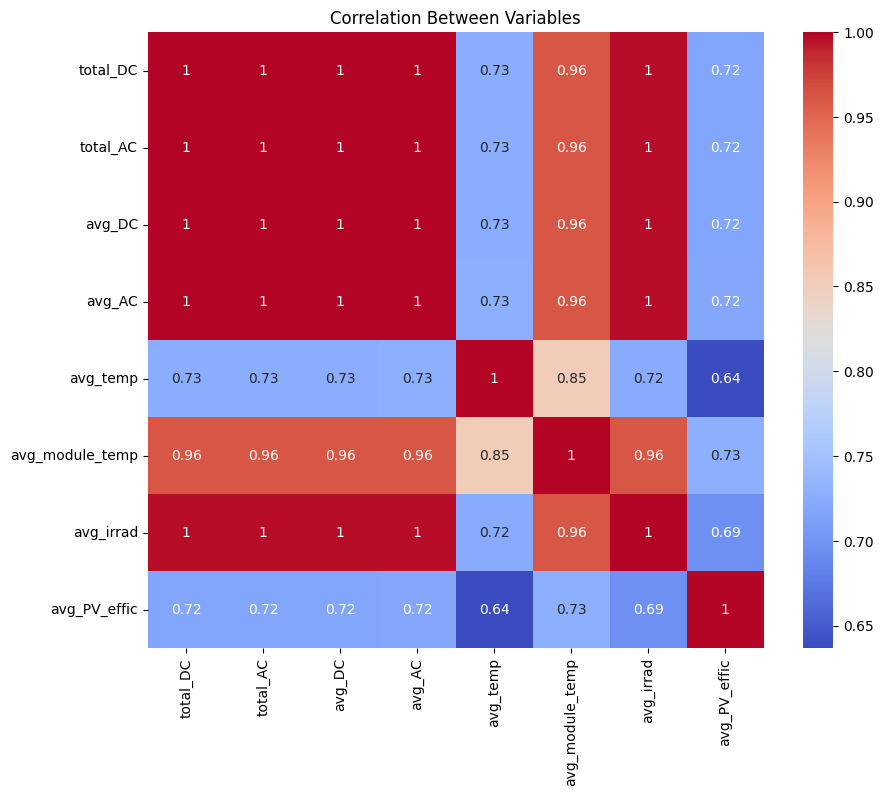

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

'''Calculate correlation matrix, by first dropping inverter efficiency variable. Inverter efficiency was a constructed variable and 
I want to focus on natural variables and their relationship to PV efficiency) in this case.'''
model_data = plant1_aggregate.drop("avg_inverter_effic",axis=1)

correlation_matrix = model_data.corr(numeric_only=True)

# Create correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", square=True)
plt.title("Correlation Between Variables")
plt.show()

Below I built the linear model of PV efficiency. I split the PV efficiency variable out and assigned it to y, while the predictor variables were grouped into df X. Then I split out the data into corresponding training and testing sets. The train_test_split function from sklearn makes this into a one liner, which was really excellent to find! Finally, I apply the LinearRegression functionality from sklearn to fit a multilinear regression model to the training data. 

I wrote a few lines to print out the actual equation. Many of the variables drop out in this process - I chose not to display variables with coefficients smaller than .001. The resulting equation shows us that there is actually a negative relationship between mean AC output and PV efficiency - when AC output increases by one unit, PV efficiency tends to decrease by 1.61. There is a similar but slightly weaker relationship between irradiance and PV efficiency as well. This model appears to confirm my hypothesis that there is a loss of efficiency as irradiance and temperature climb. The relationship between temperature and efficiency is positive, but small. 

It's worth noting that this is, of course, an approximation of the relationship between these variables. The intercept is -0.195, meaning that the expected value for PV efficiency is 0 if all independent variables are set to zero. Of course, if irradiance were zero, there would be no light to generate power from, so the real value of PV efficiency would be 0, not -0.195. It is encouraging that the model went negative in this case though.

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Select the numeric variables for the independent variables
X = model_data[['total_DC', 'total_AC', 'avg_DC', 'avg_AC', 'avg_temp', 'avg_module_temp', 'avg_irrad']]

# Select the target variable
y = model_data['avg_PV_effic']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and fit the linear regression model using the training set
model = LinearRegression()
model.fit(X_train, y_train)

coefficients = model.coef_
intercept = model.intercept_

# Create a list of variable names
variable_names = ['total_DC', 'total_AC', 'avg_DC', 'avg_AC', 'avg_temp', 'avg_module_temp', 'avg_irrad']

# Generate the model equation
equation = "avg_PV_effic = {:.3f}".format(intercept)
for i, coeff in enumerate(coefficients):
    if np.abs(coeff) > 0.001:  # Only include variables with coefficients greater than 0.01 (adjust threshold as needed)
        equation += " + {:.3f} * {}".format(coeff, variable_names[i])

print("Model equation:", equation)



Model equation: avg_PV_effic = -0.195 + -0.007 * total_DC + 0.076 * total_AC + 0.159 * avg_DC + -1.612 * avg_AC + 0.009 * avg_temp + 0.004 * avg_module_temp + -1.062 * avg_irrad


Next I use the .score() method, applying the model to the test data subsets. It returns an R-squared of 0.66, meaning that the independent variables were able to correctly explain 66% of the variance in PV efficiency. This is fairly helpful, but not a particularly strong model. I would not trust it to predict power output for an asset I manage for work, for example. 

In [18]:

# Evaluate the model on the testing set
r2_score = model.score(X_test, y_test)

# Print the R-squared score
print("R-squared score: {:.2f}".format(r2_score))

R-squared score: 0.66


**Conclusion**

This project taught me so much about Python, and working with project-level renewable energy data. I ran out of time to implement some additional models I was excited to try, namely trying to use Prophet for time series prediction and graphing. I wasn't able to install the fbprophet package to begin this process. I received this error in the Terminal: ERROR: Could not build wheels for fbprophet, pysimdjson, which is required to install pyproject.toml-based projects. (I'd love your thoughts on this, Patrick) I also failed to get dummy variables to work for improving the linear regression model - this is something I've been successful with before in R (factoring seasonality into temperature models) so that was frustrating. I'll continue to improve this project and plan to share it on my Github as well. 

In any case, I was able to join, clean, transform, visualize, and model real, publically available PV data. There are strong correlations between the environmental attributes of the project (irradiance, temperature) and the actual performance of the project. PV efficiency increases with irradiance to a point, but too much irradiance can actually hurt efficiency. Temperature has a weak impact on efficiency. These hypotheses are confirmed!

Additional exploration I would like to do here would be to apply the models I build to another project, to see if they hold true. I'd also like to get true time series - specific models working, rather than just the simple linear regression I included here.

References:

Harris, C. R., Millman, K. J., van der Walt, S. J., Gommers, R., Virtanen, P., Cournapeau, D., ... Oliphant, T. E. (2020). Array programming with NumPy. Nature, 585(7825), 357-362. doi: 10.1038/s41586-020-2649-2

Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. Computing in Science & Engineering, 9(3), 90-95. doi: 10.1109/MCSE.2007.55

McKinney, W. (2010). Data structures for statistical computing in Python. In Proceedings of the 9th Python in Science Conference (pp. 56-61). doi: 10.25080/Majora-92bf1922-00a

National Renewable Energy Laboratory. (n.d.). PV cell and module basics. Retrieved May 7, 2023, from https://www.nrel.gov/pv/cell-module-basics.html

Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... Vanderplas, J. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12, 2825-2830.

Python Software Foundation. (2020). Python Language Reference, version 3.8.2. Retrieved from https://docs.python.org/3.8/reference/index.html

Sievert, C. (2019). Interactive web-based data visualization with R, plotly, and shiny. Chapman and Hall/CRC.





Appendices:

In [ ]:

def get_notebook_path():
    """Return the path of the current Jupyter Notebook including the file name."""
    try:
        # Get the absolute path of the notebook file
        notebook_path = os.path.abspath(".ipynb")
    except NameError:
        # If __file__ is not defined, fallback to the current working directory
        notebook_path = os.getcwd()
    
    return notebook_path

# Get the path to the current notebook including the file name
notebook_path = get_notebook_path()
print("Notebook path:", notebook_path)

In [ ]:
import nbformat

def get_word_count(notebook_path):
    notebook = nbformat.read(notebook_path, as_version=nbformat.NO_CONVERT)
    word_count = 0

    for cell in notebook['cells']:
        if cell['cell_type'] == 'markdown':
            # Split the markdown cell content by whitespace to count words
            words = cell['source'].split()
            word_count += len(words)

    return word_count

# Specify the path to your .ipynb file

# Get the word count for markdown sections in the notebook
total_word_count = get_word_count(notebook_path="/Users/harrypodolsky/Desktop/ROUX/ALY 6140/Final Project/final_project_EDA.ipynb")
print("Total word count for markdown sections:", total_word_count)

Below was a little bit of failure! I wanted to assign the grid intensity variable as a dummy variable to feed back into a new linear model, and see if it would improve the predictive ability. I was not able to get the data types to play nicely, and I am not totally sure why. I ran out of time to trouble shoot this before deadline! Including for context.

In [ ]:
# from sklearn.metrics import mean_squared_error

# numeric_cols = ['total_DC', 'total_AC', 'avg_DC', 'avg_AC', 'avg_temp', 'avg_module_temp', 'avg_irrad', 'avg_PV_effic']
# model_data[numeric_cols] = model_data[numeric_cols].astype(float)


# # Create a dummy variable from the 'grid_intensity' column
# dummy_df = pd.get_dummies(model_data['grid_intensity'], prefix='grid', drop_first=True)

# # Concatenate the dummy variable with the original dataframe
# df_with_dummy = pd.concat([model_data, dummy_df], axis=1)
# dummy_cols = ['grid_off-peak', 'grid_peak']
# df_with_dummy[dummy_cols] = df_with_dummy[dummy_cols].astype(float)
# # Define the feature matrix X and the target variable y
# X = df_with_dummy.drop(['avg_PV_effic', 'grid_intensity'], axis=1)

# y = df_with_dummy['avg_PV_effic']

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Fit a linear regression model
# model = LinearRegression()
# model.fit(X_train, y_train)

# # Predict on the testing set
# y_pred = model.predict(X_test)

# # Calculate the mean squared error
# mse = mean_squared_error(y_test, y_pred)
# print("Mean Squared Error:", mse)